In [1]:
using Pkg
Pkg.add("Infinity")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [3]:
using Infinity
using Random
using Distributions

In [4]:
using NBInclude
@nbinclude("smoothing_traffic_flow_functions.ipynb")

#Scenario 1 is sharp braking at 20 seconds
#Scenario 2 is random distribution of vehicles and uniform distribution of initial velocity
#Scenario 3 is Experiment B of "Controllability Analysis and Optimal Control of Mixed Traffic Flow with Human-driven and Autonomous Vehicles"
scenario = 3

#If spacing_or_velocity == 0 then display spacing graph, if 1 then display velocity graph, if 2 then display position color graph
spacing_or_velocity =  2

# Mix or not
mix = 1

# 1.Optimal Control  2.FollowerStopper  3.PI with Saturation
controllerType = 1


brakeID = 6 - 1
# In the simulation, the ID of the AV is 20, and thus the brakeID needs to minus one    

#Chose number of Vehicles
N = 20

#Choose circumference of track (0) or equilibrium spacing of vehicles s_star (1)
#If circumference is chosen then you may ignore value of spacing and same for spacing
circumference_or_spacing = 0
circumference = 400
s_star = 20    #19.36 for 14m/s v*   #20.63 for 16m/s v*   #20 for 15m/s v*      #for Experiment 7 from scenario 2 set just s_ctr to these values

if circumference_or_spacing > 1
    circumference = s_star*N
elseif circumference_or_spacing == 0
    s_star = circumference/N
end


if mix == 1 && controllerType == 1
    gammaType = 1
    if gammaType == 1
        gamma_s = 0.03
        gamma_v = 0.15
        gamma_u = 1
    elseif gammaType == 2
        gamma_s = 3
        gamma_v = 15
        gamma_u = 1
    end
end

K = lqr_sdp(N,s_star,gamma_s,gamma_v,gamma_u,1)


┌ Warning: Concatenating collections of constraints together with `+` or `+=` to produce a new list of constraints is deprecated. Instead, use `vcat` to concatenate collections of constraints.
└ @ Convex ~/.julia/packages/Convex/QKz6m/src/deprecations.jl:129
┌ Warning: Using `x in SDP` to construct a semidefinite constraint is deprecated. Use `isposdef(x)` or `x ⪰ 0` instead.
└ @ Convex ~/.julia/packages/Convex/QKz6m/src/deprecations.jl:50
[ Info: [Convex.jl] Compilation finished: 6.29 seconds, 673.213 MiB of memory allocated


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2420            
  Affine conic cons.     : 4 (3362 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 1681            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 820
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes     

1×40 Matrix{Float64}:
 0.375455  0.121295  0.397391  0.0148385  …  -0.0147692  -0.151178  1.1923

In [5]:
print(K, "\n \n", size(K))

[0.3754545412139123 0.12129465884419655 0.3973913622726286 0.014838472086857957 0.3521597143771942 -0.06478341395449073 0.2653329195306924 -0.10974014319060466 0.16401377330112155 -0.12163155639948596 0.07030260823307799 -0.10897702371231265 -0.002469102675377144 -0.08330046722493373 -0.05025309679217571 -0.05529433157863971 -0.07616807356407662 -0.032239856752304126 -0.08707352955184433 -0.017192646515460708 -0.09025729647328262 -0.00972002727944972 -0.09123944630846381 -0.007483097425990409 -0.09302236257963159 -0.007848912843264569 -0.09650407346612155 -0.008953219958011509 -0.10144970728538283 -0.010025108978805491 -0.10742613022716796 -0.011118720732891132 -0.11432602163267802 -0.01253342949531681 -0.12236107068042656 -0.014147616528764057 -0.13155449667942776 -0.014769158751408286 -0.15117783982418587 1.1923038942096826]
 
(1, 40)

In [6]:
alpha_k = 0.6
    
v_max = 30
acel_max = 5
dcel_max = -5
#Driver Model: OVM
alpha = 0.6
beta = 0.9
s_st = 5
s_go = 35

35

In [7]:
if (scenario==1) || (scenario==2)
    TotalTime=100
elseif (scenario==3)
    TotalTime = 700
end

Tstep = 0.01
NumStep = Int(TotalTime/Tstep)

if mix > 0
    ActuationTime = 0  
else
    ActuationTime = 9999
end

ActuationTimeEnd = Inf

if (scenario==3)
    ActuationTime = 300
    ActuationTimeEnd = Inf        #Change to 450 for experiment B of Controllability Analysis
end



Inf

In [8]:
v_star  = (v_max/2) * (1-cos(pi * (s_star - s_st)/(s_go - s_st)))
s_ctr  = s_star
v_ctr  = (v_max/2) * (1-cos(pi * (s_ctr - s_st)/(s_go - s_st)))

14.999999999999995

In [9]:
sd = 5 # Collision avoidance safe distance

S = zeros(NumStep,N,3)

#Initial state for each vehicle
if (scenario == 1) || (scenario==3)
    dev_s = 0
    dev_v = 0
    co_v = 1.0
elseif scenario == 2      #Not necessary unless new random numbers needed
    dev_s = 7.5
    dev_v = 4
    co_v = 1.0    
end

v_ini = co_v * v_star   

14.999999999999995

In [10]:
Random.seed!(156379)

var1 = LinRange(circumference, s_star, N)
var2 = randn(N).*2 .*dev_s.-dev_s    
S[1, begin:end, 1] = var1 + var2
    
var1 = v_ini*ones(N)
var2 = (randn(N) .*2 .*dev_v .-dev_v)    
S[1, begin:end, 2] =  var1 + var2

20-element Vector{Float64}:
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995
 14.999999999999995

In [11]:
ID = zeros(N)

if mix == 1
    ID[end] = 1
    X = zeros(2*N, NumStep)
end

40×70000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [12]:
size(X)

(40, 70000)

In [13]:
#Velocity difference
V_diff = zeros(NumStep,N)

#Following Distance
D_diff = zeros(NumStep,N)
temp = zeros(N)


#Average Speed
V_avg = zeros(NumStep,1)
v_cmd = zeros(NumStep,1)   #For controller's 2 and 3

70000×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [14]:
##Simulation

for k = 1:(NumStep-2)
    
    #Car in front velocity
    temp[2:end] = S[k,begin:end-1,2]
    temp[1] = S[k,end,2]
    V_diff[k,begin:end] = temp.-S[k,begin:end,2]

    temp[1]=S[k,end,1].+circumference
    temp[2:end] = S[k,begin:end-1,1]

    D_diff[k,begin:end] = temp-S[k,begin:end,1]

    cal_D = D_diff[k,begin:end]
    cal_D[cal_D .>s_go] .= s_go
    cal_D[cal_D .<s_st] .= s_st
    
    #OVM Model
    
    acel2 = pi.*(cal_D.-s_st)./(s_go-s_st)
    acel1 = (1 .- cos.(acel2))
    acel3 = zeros(N)
    
    if scenario==3
        d = Normal(0, sqrt(0.5))
        acel3 = rand(d, N)#np.random.normal(0,math.sqrt(0.5),N)
    end
    
    acel = alpha.*(v_max./2 .*acel1 .-S[k,begin:end,2]) + beta .*V_diff[k,begin:end] + acel3
    acel[acel .>acel_max] .= acel_max
    acel[acel .<dcel_max] .= dcel_max

    #SD as ADAS to prevent crash
    temp[2:end] = S[k,begin:end-1,2]
    temp[1] = S[k,end,2]
    acel_sd = @. (S[k,begin:end,2]^2-temp^2)/2/(D_diff[k,begin:end]-sd)
    acel[acel_sd .>abs(dcel_max)] .= dcel_max
    
    S[k,begin:end,3] = acel
    
    
    
    if ((k-1)*Tstep>20) && ((k-1)*Tstep<23) && (scenario == 1)
        S[k,brakeID,3]=-3
    end
    
    if ((k-1)>=(ActuationTime / Tstep)) && ((k-1)< (ActuationTimeEnd / Tstep)) && (mix==1)
        if controllerType==1
                    X[1:2:39,k] = @. D_diff[k,begin:end]-s_ctr
                    X[2:2:40,k] = @. S[k,begin:end,2]-v_ctr
                    u = -K*X[begin:end,k]
        elseif controllerType==2
            dx10 = 9.5
            dx20 = 10.75
            dx30 = 11

            dv_temp = min(S[k,end-1,2]-S[k,end,2],0)

            d1 = 1.5
            d2 = 1.0
            d3 = 0.5
            
            dx1 = dx10+dv_temp^2/2/d1
            dx2 = dx20+dv_temp^2/2/d2
            dx3 = dx30+dv_temp^2/2/d3

            dx = D_diff[k,N]
            v_temp = min(S[k,end-1,2],12)

            if dx<=dx1
                v_cmd = 0
            elseif dx<=dx2                                                        #??????? d2 is greater than d3
                v_cmd = v_temp*(dx-dx1)/(dx2-dx1)
            elseif dx<=dx3
                v_cmd = v_temp+(v_ctr-v_temp)*(dx-dx2)/(dx3-dx2)
            else
                v_cmd = v_ctr
            end

            u = alpha_k*(v_cmd.-S[k,end,2])

        elseif controllerType==3
            gl = 7
            gu = 30
            v_catch = 1
            gamma_temp = 2


            if (k-1)-38/Tstep<=ActuationTime/Tstep
                v_hisAvg = mean(S[Int(ActuationTime/Tstep):k,end,2])
            else
                v_hisAvg = mean(S[Int(((k-1)-38/Tstep)-ActuationTime/Tstep):k,end,2])
            end

            v_target = v_hisAvg + v_catch*min(max((D_diff[k,end]-gl)/(gu-gl),0),1)
            alpha_temp = min(max((D_diff[k,-1]-max(2*V_diff[k,end],4))/gamma_temp, 0),1)
            beta_temp = 1-0.5*alpha_temp
            v_cmd[k+1] = beta_temp*(alpha_temp*v_target+(1-alpha_temp)*S[k,end-1,2])+(1-beta_temp)*v_cmd[k]
            u = alpha_k*(v_cmd[k+1]-S[k,end,2])
        end
        
        if u[1]>acel_max
            u.=acel_max
        elseif u[1]<dcel_max
            u.=dcel_max
        end

        if ( ( (S[k,end,2]^2-S[k,end-1,2]^2) /2 ) / (S[k,end-1,1]-S[k,end,1]-sd) )>abs(dcel_max)
            u=dcel_max
        end
        # print(S[k,-1,1]**2-S[k,-2,1]**2)
        # print((S[k,-2,0]-S[k,-1,0]-sd))
        # print( ( (S[k,-1,1]**2-S[k,-2,1]**2) /2 ) / (S[k,-2,0]-S[k,-1,0]-sd) )            
        # print(S[k,-2,0])
        # print(S[k,-1,0])
        # print(u)
        S[k,end,3] = u[1]
    end
        S[k+1,begin:end,2] = S[k,begin:end,2] + Tstep*S[k,begin:end,3]
        S[k+1,begin:end,1] = S[k,begin:end,1] + Tstep*S[k,begin:end,2]
        
end # end of simulation

In [15]:
for k = 1:NumStep
    V_avg[k] = mean(S[k,begin:end,2])
end
    
   
#Settling Time
final_velocity = V_avg[NumStep-1]
above_2_percent = final_velocity*1.03
below_2_percent = final_velocity*0.97

settling_time = 0
for k = NumStep-1:-1:1
    for j = 1:N
        if (S[k,j,2] > above_2_percent) || (S[k,j,2] < below_2_percent)
            settling_time = k/100
            break
        end
    end
    if (settling_time != 0)
        break
    end
end
    
print("Settling Time within 3% is",settling_time, "s \n")



#Maximum Spacing in fron of AV
max_space = 0
for k = 1:NumStep
    curr_space = S[k,end-1,1]-S[k,end,1]
    if ( curr_space > max_space)
        max_space = curr_space
    end
end
print("Maximum Spacing in front of AV is ", max_space, " \n")

#Average settled velocity
print("Average settled velocity is ", mean(S[(Int((0.9*TotalTime)/Tstep)):end,begin:end,2]),2, " m/s")


Settling Time within 3% is354.79s 
Maximum Spacing in front of AV is 81.6315481225347 
Average settled velocity is 14.9992672682550892 m/s

(70000, 20)

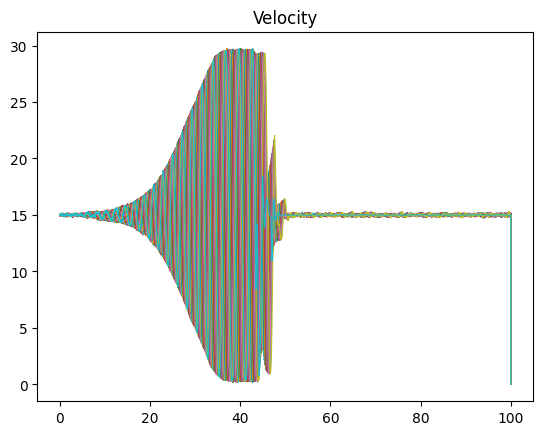

PyObject Text(0.5, 1.0, 'Velocity')

In [16]:
using PyPlot
print(size(S[:,:,2]))
xAxis = LinRange(0, 100, NumStep)
plot(xAxis,S[:,:,2],linewidth=0.75)
title("Velocity")

In [22]:
using PyCall
run(`$(PyCall.python) -m pip install PyQt5`)
# 或者使用 PySide2
run(`$(PyCall.python) -m pip install PySide2`)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.3/164.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.4/975.4 kB 17.9 MB/s eta 0:00:00


Process(`python3 -m pip install PySide2`, ProcessExited(0))

In [26]:
using PyCall
pygui(:qt5)
using PyPlot

#Display Data:
fig = figure()
x = 1:NumStep
yticks = LinRange(0,NumStep,5)
yticklabels = LinRange(0,TotalTime,5)

# syntax for 3-D projection

if spacing_or_velocity == 0
    ax = PyPlot.axes(projection = "3d")
    for i = 1:N
        z = ones(Numstep-1)*i

        if ID[i] == 1
            ax.plot3D(z, x[begin:end-1], S[begin:end-1,i - 1, 1] - S[begin:end-1, i, 1],  "red", linewidth = 0.5)
            continue
        end
        
        if i == 1
            ax.plot3D(z, x[begin:end-1], S[begin:end-1,i-1,1] - S[begin:end-1,i,1] + Circumference, "blue", linewidth=0.5)
            continue
        end

        ax.plot3D(z, x[begin:end-1], S[begin:end-1,i-1,1] - S[begin:end-1,i,1], "blue", linewidth=0.5)
            
    end
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel("Vehicle ID")
    ax.set_ylabel("Time")
    ax.set_zlabel("Spacing from vehicle ahead")
    PlotTitle = join(["N=", string(N), ", mix=", string(mix) ])
    ax.set_title(PlotTitle)
    show()
end

if spacing_or_velocity == 1
    ax = PyPlot.axes(projection = "3d")
    for i = 1:N
        z = ones(NumStep-1)*i

        # if i==N-1 and mix==1:
        if ID[i] == 1
            ax.plot3D(z, x[begin:end-1], S[begin:end-1,i,2], "red", linewidth=0.5)
            continue
        end
        
        ax.plot3D(z, x[begin:end-1], S[begin:end-1,i,2], "blue", linewidth=0.5)

    end
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel("Vehicle ID")
    ax.set_ylabel("Time")
    ax.set_zlabel("Vehicle Velocity")
    PlotTitle = join(["N=", string(N), ", mix=", string(mix) ]) # "N="# + str(N) + ", mix=" + str(mix) 
    ax.set_title(PlotTitle)
    show()
end

if spacing_or_velocity == 2
    #using PyCall
    #plt = pyimport("matplotlib")
    for i = 1:N
        y = S[begin:end,i,1] .%circumference
        y[y.>399] .= NaN

        z = S[begin:end,i,2]
        points = reshape([x; y]',(:,1,2))
        segments = cat([points[begin:end-1,:,:],points[2:end,:,:]],dims=2)
        
        if i == 1 
            print([[(points[1,1,1],points[1,1,2]),(points[2,1,1],points[2,1,2])]])
            print(typeof([[(points[1,1,1],points[1,1,2]),(points[2,1,1],points[2,1,2])]]))
            #print(segments[:,1,1])
        end

        for j = 1:3#NumStep-1
            lc = matplotlib.collections.LineCollection([[(points[j,1,1],points[j,1,2]),(points[j+1,1,1],points[j+1,1,2])]] , array=z[1], cmap=matplotlib.colors.LinearSegmentedColormap.from_list("rg",["black","r", "orange", "y", "limegreen"], N=256), norm=matplotlib.colors.Normalize(0,25),  linewidth=0.5)#, alpha=alpha)
            ax = plt.gca()
            ax.add_collection(lc)
        end
    end
    

    plt.xlim(20000, 60000)
    plt.ylim(0,400)
    plt.show()
end

[[(1.0, 0.0), (2.0, 0.14999999999997726)]]Vector{Vector{Tuple{Float64, Float64}}}

Figure(PyObject <Figure size 640x480 with 1 Axes>)